<img align="center" src="img/course.png" width="800">

# 16720 (B)  Object Tracking in Videos - Assignment 6 - Q1
    Instructor: Kris                          TAs: Arka, Rohan, Rawal, Sheng-Yu, Jinkun


In [ ]:
# Libraries

import numpy as np
from scipy.interpolate import RectBivariateSpline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

## Q1: Lucas-Kanade Forward Additive Alignment for Tracking

### Overview
In this part, you will implement two variants of the Lucas-Kanade Tracking algorithm:

- The warp $W$ being translation only
- The warp $W$ being the full affine transformation

and evaluate them on the provided videos, which can be downloaded [here](https://www.dropbox.com/sh/l2ip26mkgf5p3e6/AACN2STT5Sk9r6bPeEXIYKZCa?dl=0). It is highly recommended that you finish the theory section first, or at the very least, go over the provided materials to gain a better understanding of the algorithms. You may also find these materials useful: [link](https://www.ri.cmu.edu/pub_files/pub3/baker_simon_2002_3/baker_simon_2002_3.pdf) and [link](https://www.ri.cmu.edu/pub_files/pub3/baker_simon_2003_3/baker_simon_2003_3.pdf).


### Q1.1:  Lucas-Kanade Forward Additive Alignment with Translation Only (10 PT write-up, 20 PT implementation)
Write the function with the following function signature:

```
            p = LucasKanade(It, It1, rect, thresh, maxIt)
```
that computes the optimal local motion $p$ represented by translation (motion in x and y directions) from frame $I_t$ to frame $I_{t+1}$ that minimizes

$$
\begin{gathered}
\mathcal{L}=\sum_{\mathbf{x}}[\mathbf{T}(\mathbf{x})-\mathbf{I}(\mathbf{W}(\mathbf{x} ; \mathbf{p}))]^{2}. 
\end{gathered}
$$

"It" is the image frame $I_t$, "It1" is the image frame $I_{t+1}$, and "rect" is a $4×1$ vector that represents a rectangle (bounding box) on the image frame $I_t$. The four elements of the rectangle are $[x1, y1, x2, y2]$, where $(x1, y1)$ is the top-left corner and $(x2, y2)$ is the bottom-right corner of the bounding box. "thresh" and "maxIt" control when the algorithm should stop, depending on if dp is too small or the maximum number of iterations has been reached, respectively.

Hints:
- To deal with the fractional movement of the template in the bounding box, you will need to interpolate the image using scipy.interpolate.RectBivariateSpline. The same function can also be used to compute the gradient of an image at a point location.
- You will need to iterate the estimation in Equation 10 until the change in warp parameters $(dx, dy)$ is below a threshold or the number of iterations is too large.
- You can use np.linalg.lstsq to solve the least square problem in Equation 10.

<span style='color:red'>**Output:**</span> In your write-up: Please include the results of the algorithm on all five videos we have provided along with your code.

In [ ]:
def LucasKanade(It, It1, rect, thresh=.025, maxIt=100):
    
    '''
    Q1.1: Lucas-Kanade Forward Additive Alignment with Translation Only
    
      Inputs: 
        It: template image
        It1: Current image
        rect: Current position of the object
        (top left, bottom right coordinates, x1, y1, x2, y2)
        thresh: Stop condition when dp is too small
        maxIt: Maximum number of iterations to run
        
      Outputs:
        p: movement vector dx, dy
    '''
    # print(It.shape)
    # print(It1.shape)
    # Set thresholds (you probably want to play around with the values)
    p = np.zeros(2) # dx, dy
    threshold = thresh
    maxIters = maxIt
    i = 0
    x1, y1, x2, y2 = rect
    
    # ----- TODO -----
    # YOUR CODE HERE
    # del_Px, del_Py = 1, 1
    del_p = np.ones(2,)
    img_t_spline = RectBivariateSpline(np.arange(It.shape[0]), np.arange(It.shape[1]), It)
    mesh_x, mesh_y = np.meshgrid(np.arange(x1,x2), np.arange(y1,y2))
    wrapped_img_t_spline = (img_t_spline.ev(mesh_y ,mesh_x)).flatten()

    img_t1_spline = RectBivariateSpline(np.arange(It1.shape[0]), np.arange(It1.shape[1]), It1)
    grady_img_t1, gradx_img_t1 = np.gradient(It1)
    gradx_img_t1_spline = RectBivariateSpline(np.arange(It1.shape[0]), np.arange(It1.shape[1]), gradx_img_t1)
    grady_img_t1_spline = RectBivariateSpline(np.arange(It1.shape[0]), np.arange(It1.shape[1]), grady_img_t1)

    curr_itr = 0
    while np.linalg.norm(del_p) > threshold and curr_itr < maxIters:
    # while curr_itr < maxIters:

      del_Px = p[0]
      del_Py = p[1]
      mesh_x_temp = mesh_x + del_Px
      mesh_y_temp = mesh_y + del_Py

      wrapped_img_t1_spline = (img_t1_spline.ev(mesh_y_temp, mesh_x_temp)).flatten()
      
      b = wrapped_img_t_spline - wrapped_img_t1_spline

      wrapped_gradx = gradx_img_t1_spline.ev(mesh_y_temp, mesh_x_temp).flatten()
      wrapped_grady = grady_img_t1_spline.ev(mesh_y_temp, mesh_x_temp).flatten()

      # A = np.column_stack((wrapped_gradx, wrapped_grady))
      A = np.stack((wrapped_gradx, wrapped_grady), axis = 1)
      # A = np.vstack((wrapped_gradx, wrapped_grady))
      # A = A.reshape((2,1))

      del_p = np.linalg.lstsq(A, b, rcond=-1)[0]
      # del_p = del_p[0]
      # print(del_p.shape)
      # if np.linalg.norm(del_p) > threshold:
      #   break
      # else:
      p += del_p
      curr_itr += 1
      
      
      


    # raise NotImplementedError()

    return p

In [ ]:
# Test your algorithm and visualize results!

# Load data
data_name = 'car2' # could choose from (car1, car2, landing, race, ballet)
data = np.load('./data/%s.npy' % data_name)

# obtain the initial rect with format (x1, y1, x2, y2)
if data_name == 'car1':
    initial = np.array([170, 130, 290, 250])
elif data_name == 'car2':
    initial = np.array([59, 116, 145, 151])
elif data_name == 'landing':
    initial = np.array([440, 80, 560, 140])
elif data_name == 'race':
    initial = np.array([170, 270, 300, 370])
elif data_name == 'ballet':
    initial = np.array([700, 210, 775, 300])
else:
    assert False, 'the data name must be one of (car1, car2, landing, race, ballet)'

numFrames = data.shape[2]
w = initial[2] - initial[0]
h = initial[3] - initial[1]

# loop over frames
rects = []
rects.append(initial)

for i in range(numFrames-1):

    It = data[:,:,i]
    It1 = data[:,:,i+1]
    rect = rects[i]

    # run algorithm and collect rects
    dx, dy = LucasKanade(It, It1, rect)
    newRect = np.array([rect[0] + dx, rect[1] + dy, rect[0] + dx + w, rect[1] + dy + h])
    rects.append(newRect)

    # Visualize
    
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.add_patch(patches.Rectangle((rect[0], rect[1]), rect[2]-rect[0]+1, rect[3]-rect[1]+1, linewidth=2, edgecolor='red', fill=False))
    # if i % 10 == 0:
    plt.imshow(It1, cmap='gray')
    plt.show()
    ax.clear()

In [ ]:
# For some transparency: we evaluate on multiple frames in a given video starting from the first frame.
# We then compare against the reference implementation and calculate the sum of all differences.
# You should not need to tune anything for the autograding. We pass in the same hyperparameters for you.


### Q1.2:  Lucas-Kanade Forward Additive Alignment with Affine Transformation (10 PT write-up, 20 PT implementation)
Assuming that the warp is translation-only is quite limiting. Now we will assume that the warp takes on the form of an arbitrary affine transformation. Write the function with the following function signature:

```
            M = LucasKanadeAffine(It, It1, rect):
```
that computes the optimal local motion represented by a $2x3$ affine transformation matrix $M$ from frame $I_t$ to frame $I_{t+1}$that minimizes

$$
\begin{gathered}
\mathcal{L}=\sum_{\mathbf{x}}[\mathbf{T}(\mathbf{x})-\mathbf{I}(\mathbf{W}(\mathbf{x} ; \mathbf{p}))]^{2}. 
\end{gathered}
$$

The inputs are structured identically to the previous problem.

<span style='color:red'>**Output:**</span> In your write-up: Please include the results of the algorithm on all five videos we have provided along with your code.

In [ ]:
def LucasKanadeAffine(It, It1, rect, thresh=.025, maxIt=100):
    '''
    Q1.2: Lucas-Kanade Forward Additive Alignment with Affine MAtrix
    
      Inputs: 
        It: template image
        It1: Current image
        rect: Current position of the object
        (top left, bottom right coordinates, x1, y1, x2, y2)
        thresh: Stop condition when dp is too small
        maxIt: Maximum number of iterations to run
        
      Outputs:
        M: Affine mtarix (2x3)
    '''

    # Set thresholds (you probably want to play around with the values)
    M = np.zeros((2,3))
    threshold = thresh
    maxIters = maxIt
    i = 0
    x1, y1, x2, y2 = rect
    
    # ----- TODO -----
    # YOUR CODE HERE
    p = np.zeros(6) # dx, dy
    del_p = np.ones(6,)
    img_t_spline = RectBivariateSpline(np.arange(It.shape[0]), np.arange(It.shape[1]), It)
    mesh_x, mesh_y = np.meshgrid(np.arange(x1,x2), np.arange(y1,y2))
    wrapped_img_t_spline = img_t_spline.ev(mesh_y ,mesh_x).flatten()
    
    img_t1_spline = RectBivariateSpline(np.arange(It1.shape[0]), np.arange(It1.shape[1]), It1)
    grady_img_t1, gradx_img_t1 = np.gradient(It1)
    gradx_img_t1_spline = RectBivariateSpline(np.arange(It1.shape[0]), np.arange(It1.shape[1]), gradx_img_t1)
    grady_img_t1_spline = RectBivariateSpline(np.arange(It1.shape[0]), np.arange(It1.shape[1]), grady_img_t1)

    homo_mesh = np.vstack((mesh_x.flatten(), mesh_y.flatten(), np.ones(mesh_x.shape[0]*mesh_x.shape[1])))
    curr_itr = 0
    while np.linalg.norm(del_p) > threshold and curr_itr < maxIters:
      
      W = np.array([[1,0,0],[0,1,0]])+np.array([[p[0], p[2], p[4]], [p[1], p[3], p[5]]])
      homo = np.array([0,0,1])
      W = np.vstack((W, homo))
      warped_block = np.matmul(W, homo_mesh)
      wrapped_img_t1_spline = img_t1_spline.ev(warped_block[1,:], warped_block[0,:])
      
      b = wrapped_img_t_spline - wrapped_img_t1_spline

      wrapped_gradx = gradx_img_t1_spline.ev(warped_block[1,:], warped_block[0,:])
      wrapped_grady = grady_img_t1_spline.ev(warped_block[1,:], warped_block[0,:])
      wrapped_gradx = np.expand_dims(wrapped_gradx, axis=1)
      wrapped_grady = np.expand_dims(wrapped_grady, axis=1)
      # print(wrapped_gradx.shape)
      grad = np.dstack((wrapped_gradx, wrapped_grady))
      x_coords = np.expand_dims(warped_block[0,:], axis=1)
      y_coords = np.expand_dims(warped_block[1,:], axis=1)
      # print(y_coords.shape)
      # print("zerp",np.zeros((x_coords.shape)).shape)
      dhoW_dhoP1 = np.dstack((x_coords, np.zeros((x_coords.shape)), y_coords, np.zeros((x_coords.shape)), np.ones((x_coords.shape)), np.zeros((x_coords.shape))))
      dhoW_dhoP2 = np.dstack((np.zeros((x_coords.shape)), x_coords, np.zeros((x_coords.shape)), y_coords, np.zeros((x_coords.shape)), np.ones((x_coords.shape))))
      # print("check", dhoW_dhoP2.shape)
      # dhoW_dhoP = np.stack((dhoW_dhoP1, dhoW_dhoP2), axis=1)
      dhoW_dhoP = np.hstack((dhoW_dhoP1, dhoW_dhoP2))
      # print("grad",grad.shape)
      # print("dhow", dhoW_dhoP.shape)
      # raise NotImplementedError()
      A = np.matmul(grad, dhoW_dhoP)
      A = A[:,0,:]
      
      del_p = np.linalg.lstsq(A, b, rcond=None)[0]
      p += del_p
      curr_itr += 1
    M = np.array([[1 + p[0], p[2], p[4]], [p[1], 1+p[3], p[5]]])
    # raise NotImplementedError()
    
    return M


In [ ]:
a = np.array([[1,0,0],[0,1,0]])
b = np.array([-1,-1,-1])
np.vstack((a, b))

In [ ]:
def LucasKanadeAffine1(It, It1, rect, thresh=.025, maxIt=100):
    '''
    Q1.2: Lucas-Kanade Forward Additive Alignment with Affine MAtrix
    
      Inputs: 
        It: template image
        It1: Current image
        rect: Current position of the object
        (top left, bottom right coordinates, x1, y1, x2, y2)
        thresh: Stop condition when dp is too small
        maxIt: Maximum number of iterations to run
        
      Outputs:
        M: Affine mtarix (2x3)
    '''

    # Set thresholds (you probably want to play around with the values)
    M = np.zeros((2,3))
    threshold = thresh
    maxIters = maxIt
    i = 0
    x1, y1, x2, y2 = rect
    
    # ----- TODO -----
    # YOUR CODE HERE
    p = np.zeros(6,)
    
    tempspline = RectBivariateSpline(np.arange(It.shape[0]), np.arange(It.shape[1]), It)
    meshX, meshY = np.meshgrid(np.arange(x1, x2), np.arange(y1, y2))
    point_vec = np.vstack((meshX.flatten(), meshY.flatten(), np.ones(meshX.flatten().shape[0])))
    template = tempspline.ev(point_vec[1,:], point_vec[0,:])
    # print(meshX.flatten().shape[0])
    # print(meshX.shape[0]*meshX.shape[1])
    
    Iy, Ix = np.gradient(It1)
    gradx_spline = RectBivariateSpline(np.arange(It1.shape[0]), np.arange(It1.shape[1]), Ix)
    grady_spline = RectBivariateSpline(np.arange(It1.shape[0]), np.arange(It1.shape[1]), Iy) 
    imspline = RectBivariateSpline(np.arange(It1.shape[0]), np.arange(It1.shape[1]), It1)
    
    while i <= maxIters:
        
        warp_matrix = np.array([[1 + p[0], p[2], p[4]], [p[1], 1 + p[3], p[5]], [0, 0, 1]])
        warped_vec = np.matmul(warp_matrix, point_vec)
        warped_Im = imspline.ev(warped_vec[1,:], warped_vec[0,:])                  
        
        b = template - warped_Im
        
        gradx_warped = gradx_spline.ev(warped_vec[1,:], warped_vec[0,:])
        grady_warped = grady_spline.ev(warped_vec[1,:], warped_vec[0,:])
        gradI = np.dstack((gradx_warped.reshape(-1,1), grady_warped.reshape(-1,1)))
        # print(gradx_warped.shape)
        # print(gradx_warped.reshape(-1,1).shape)
        # print(np.expand_dims(gradx_warped, axis=1).shape)
        warped_x = warped_vec[0, :]
        warped_y = warped_vec[1, :]
        N = warped_x.shape[0]
        # print(warped_x.shape)
        # print(warped_y.reshape(-1,1).shape)
        dW_dP1 = np.dstack((warped_x.reshape(-1,1), np.zeros((N,1)), warped_y.reshape(-1,1), np.zeros((N,1)), np.ones((N,1)), np.zeros((N,1))))
        dW_dP2 = np.dstack((np.zeros((N,1)), warped_x.reshape(-1,1), np.zeros((N,1)), warped_y.reshape(-1,1), np.zeros((N,1)), np.ones((N,1))))
        # print("first",dW_dP1.shape)
        dW_dP = np.hstack((dW_dP1, dW_dP2))
        
        # print("grad", gradI.shape)
        print("dW", dW_dP.shape)
        A = np.matmul(gradI, dW_dP)
        A = np.squeeze(A, axis = 1)
        
        
        output = np.linalg.lstsq(A, b, rcond=None)
        del_p = output[0]
        p = p + del_p
        
        if np.linalg.norm(del_p) < threshold:
            break
            
        i = i + 1
    
    M = np.array([[1 + p[0], p[2], p[4]], [p[1], 1+p[3], p[5]]])
    return M


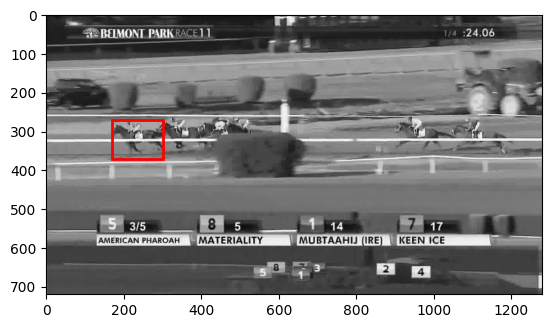

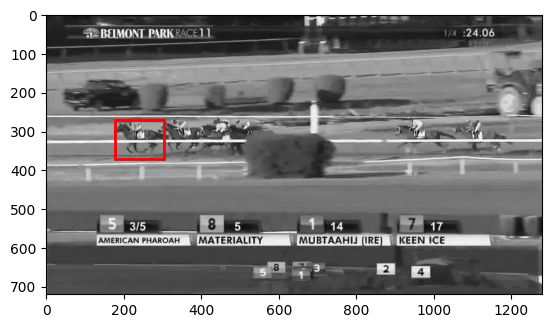

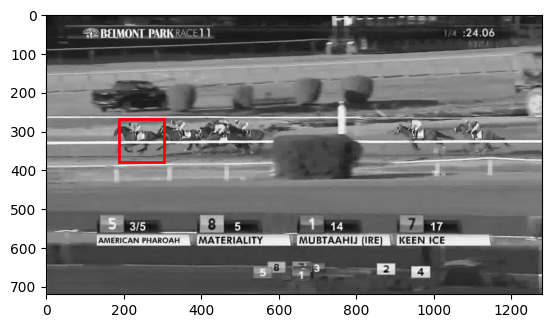

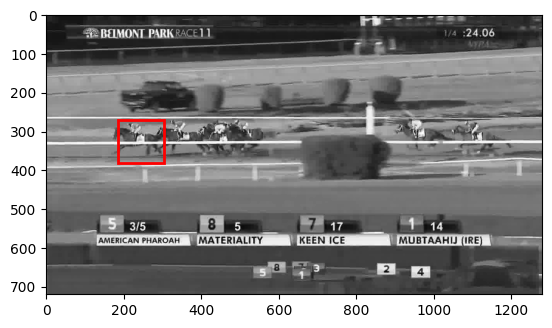

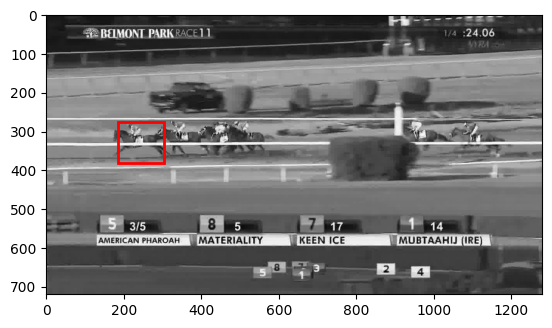

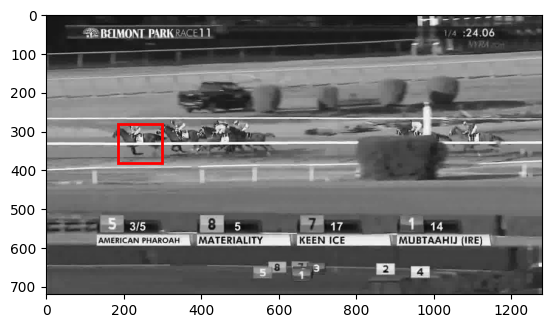

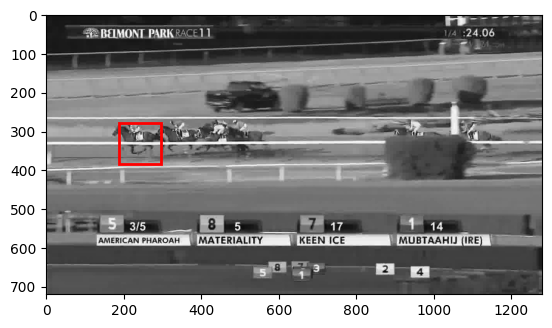

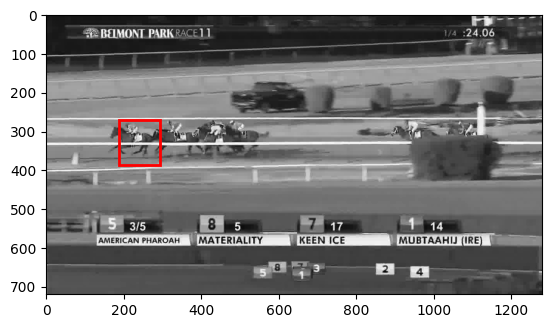

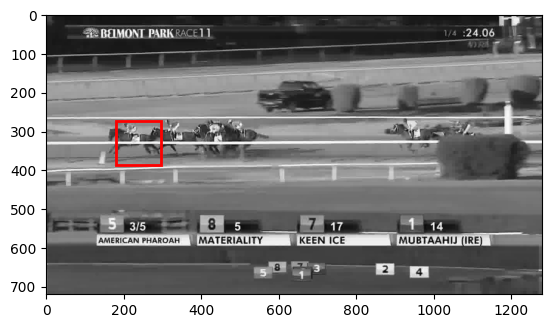

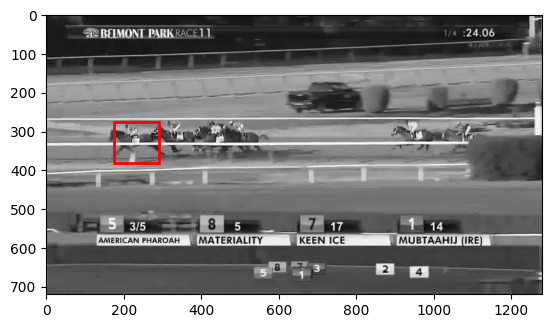

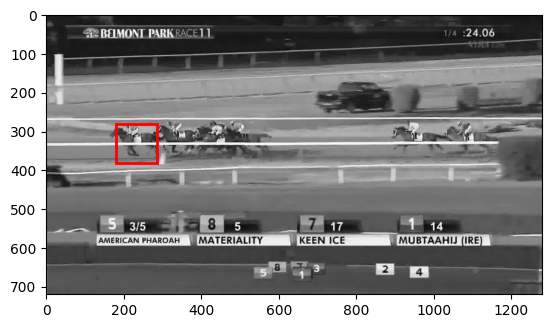

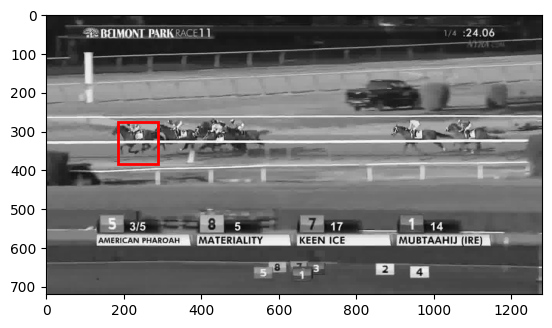

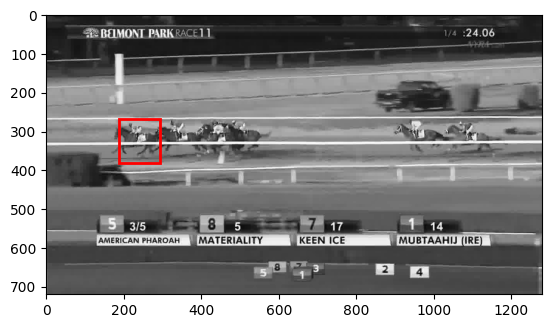

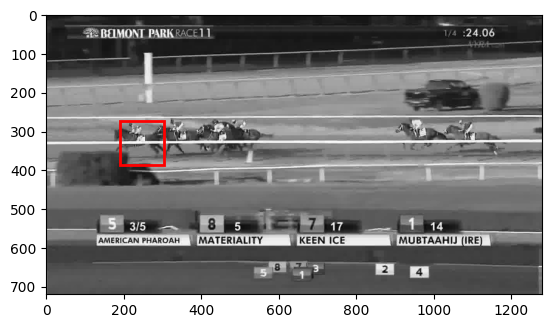

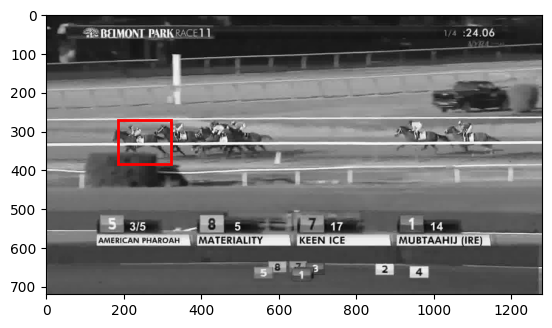

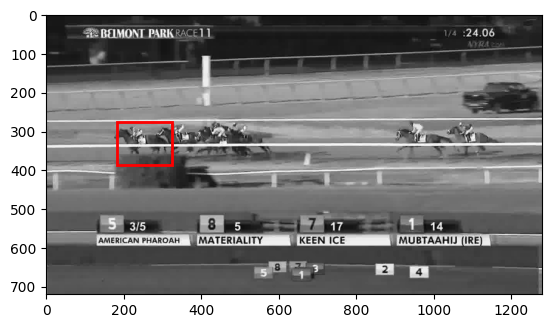

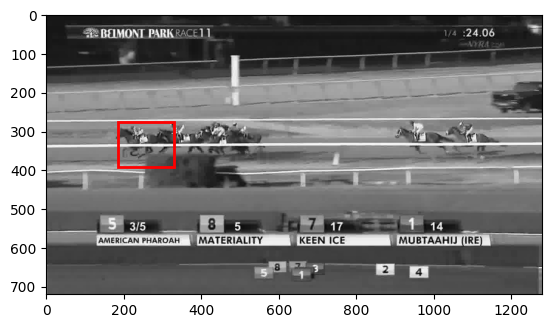

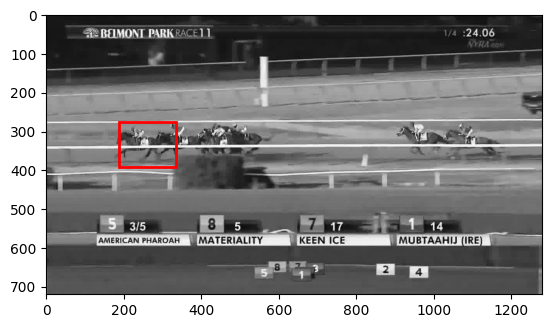

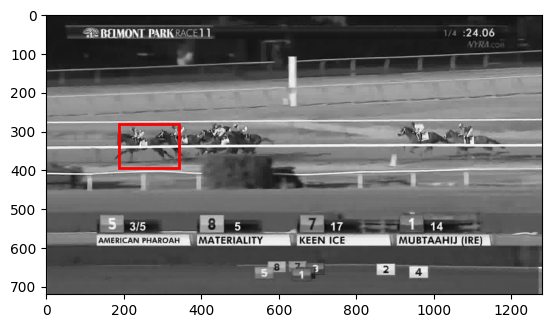

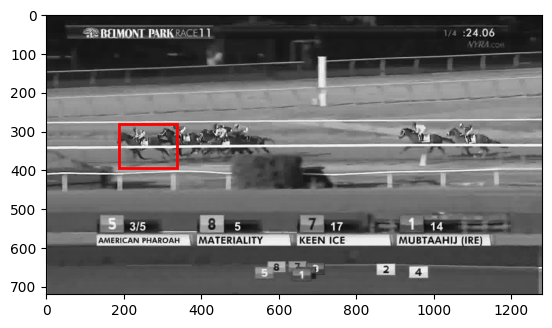

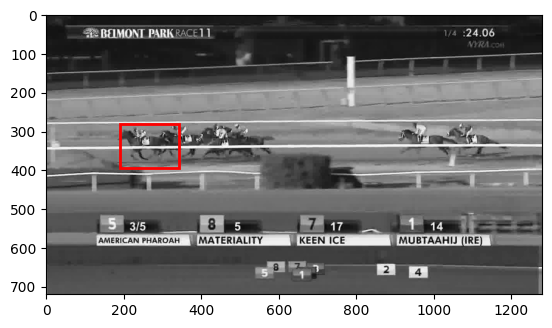

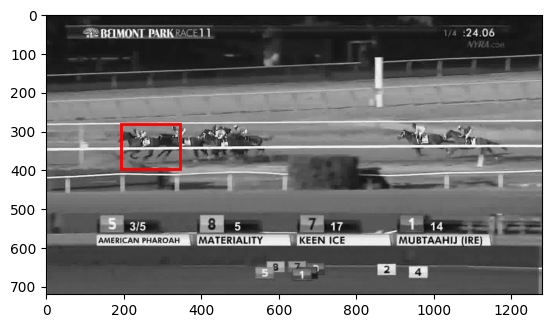

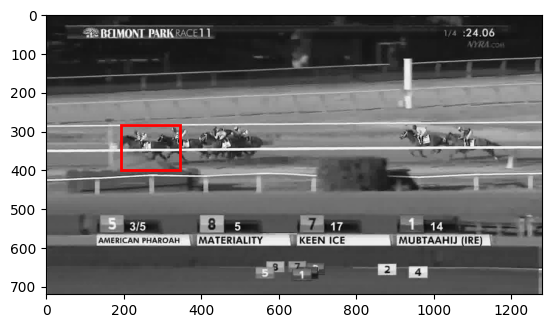

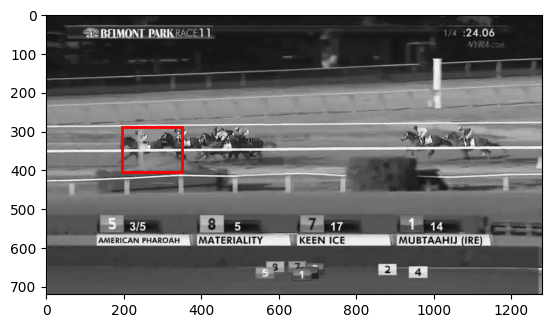

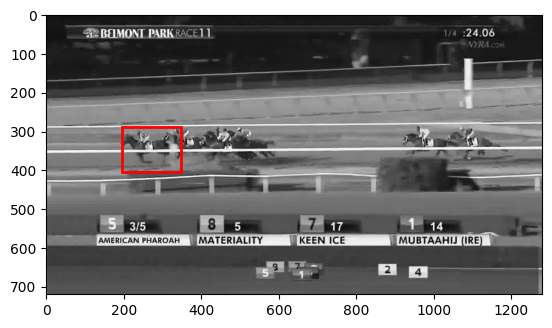

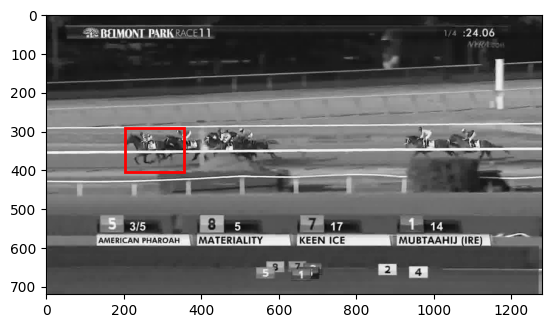

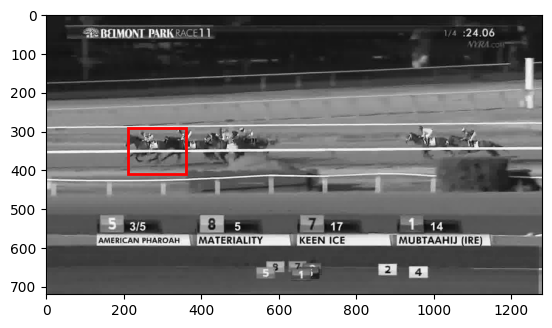

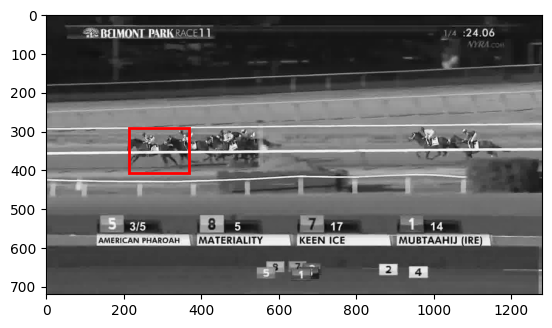

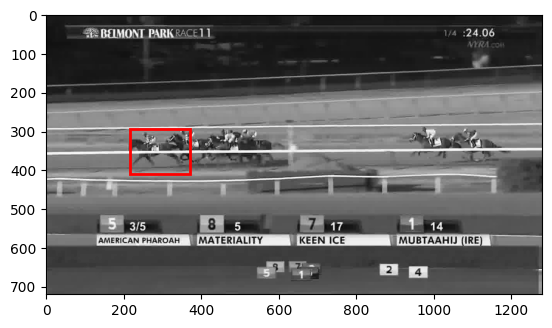

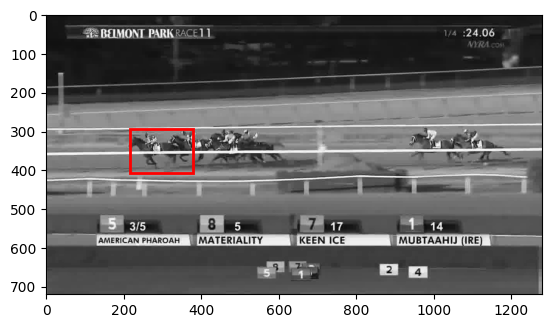

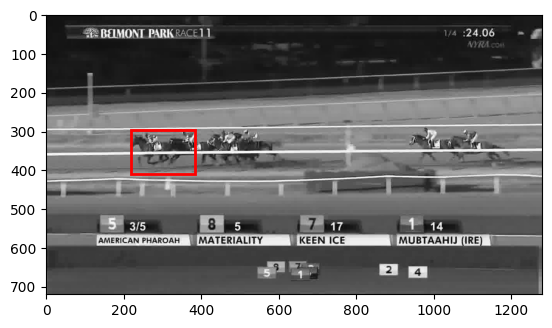

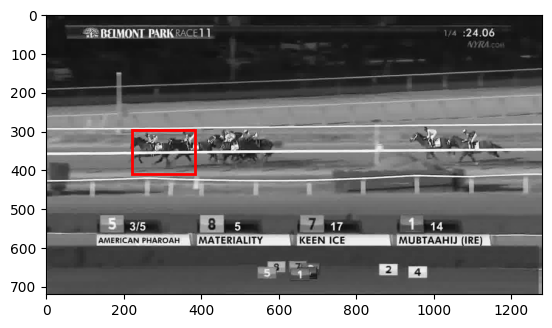

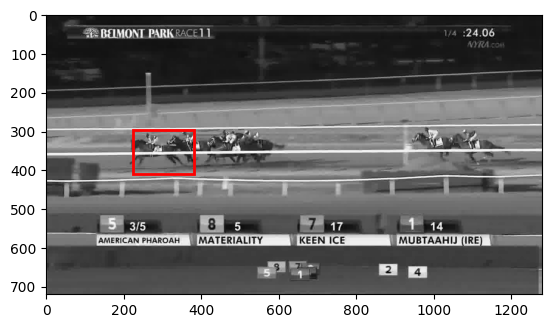

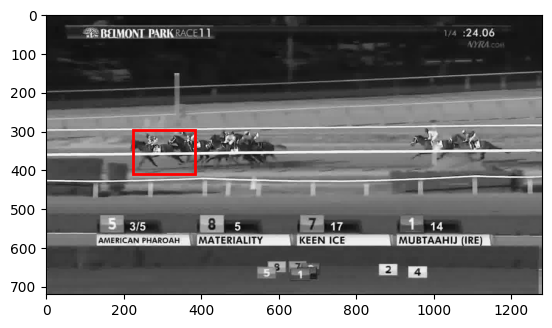

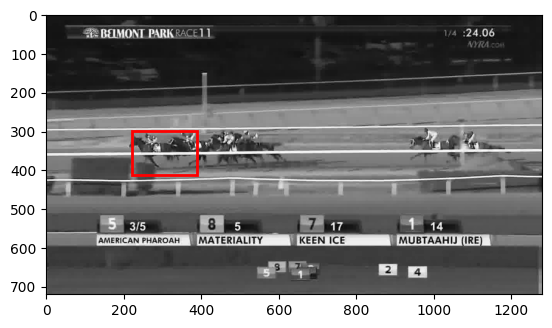

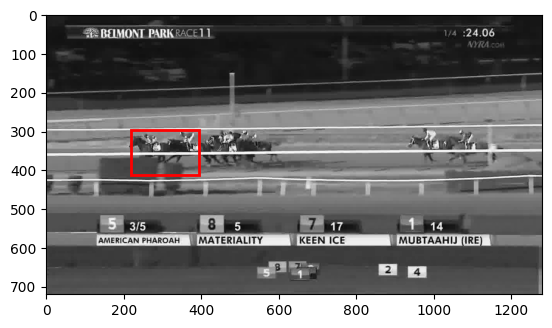

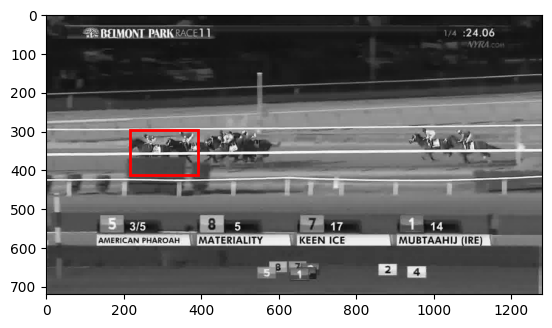

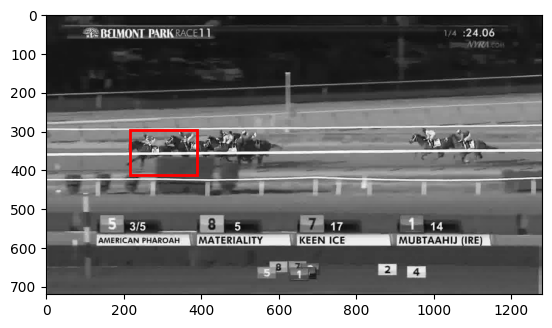

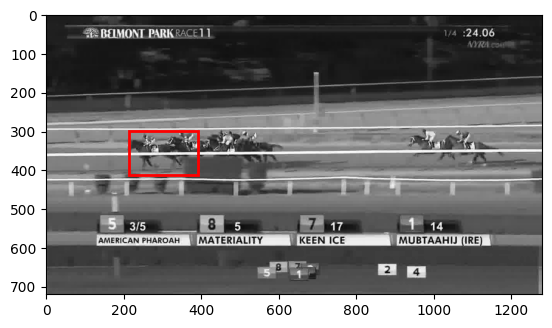

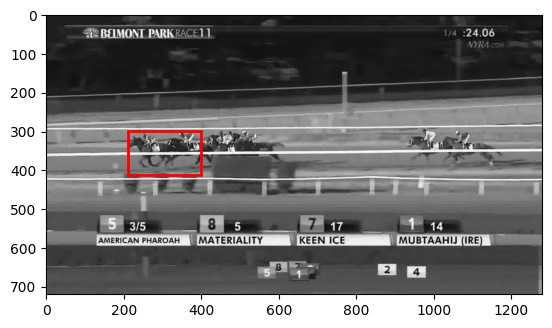

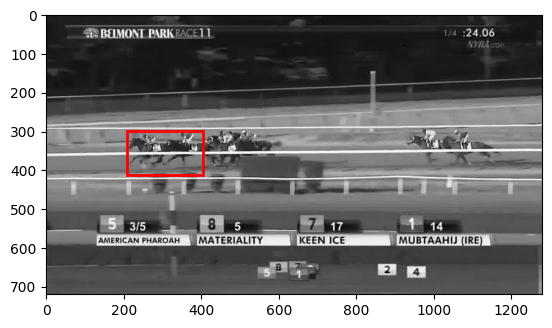

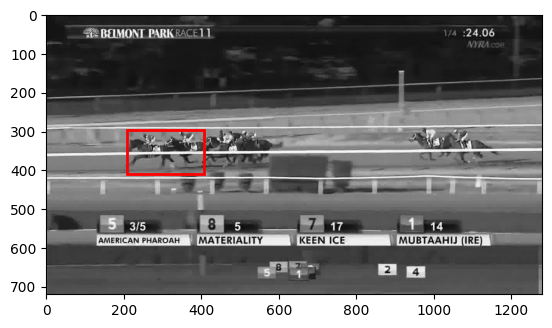

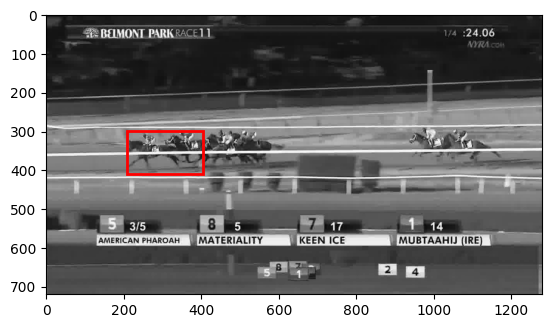

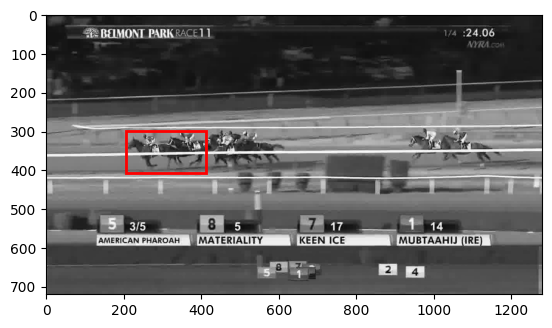

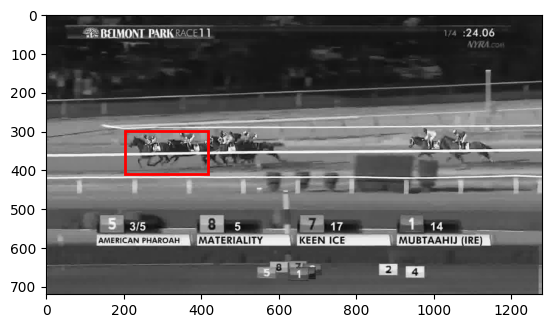

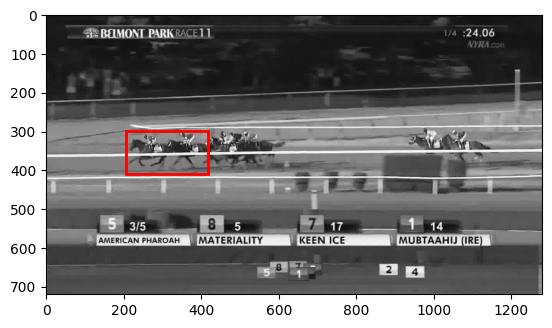

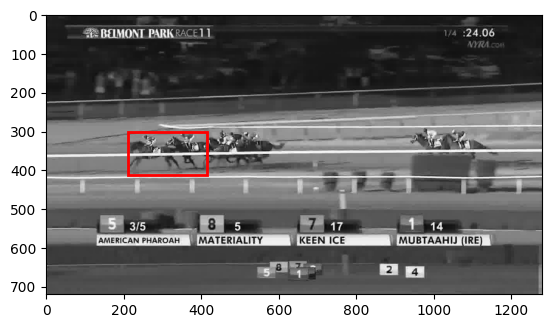

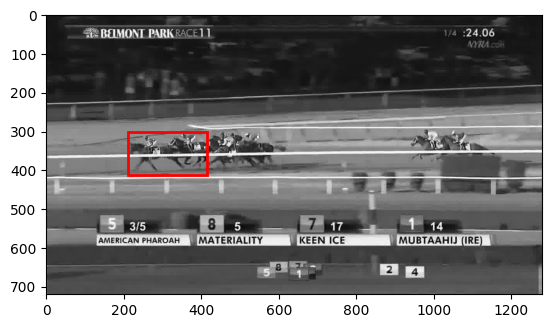

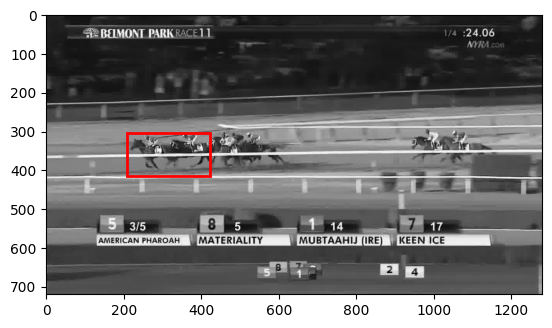

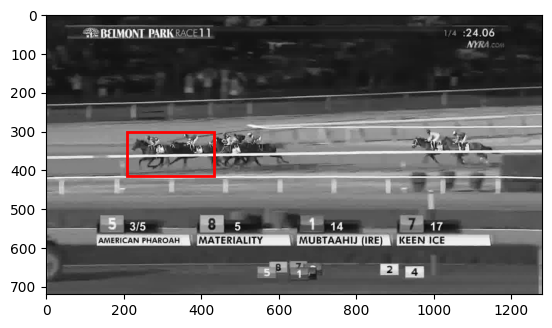

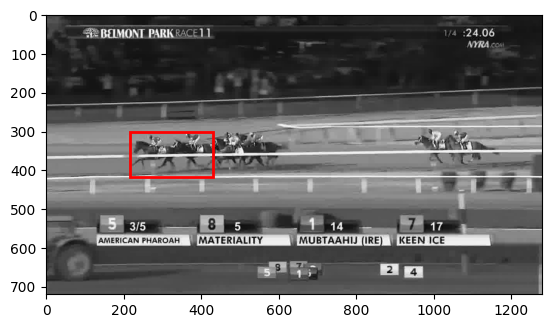

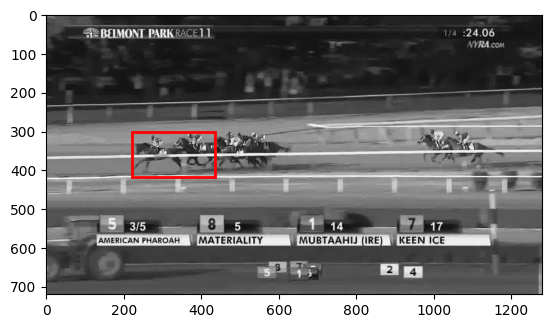

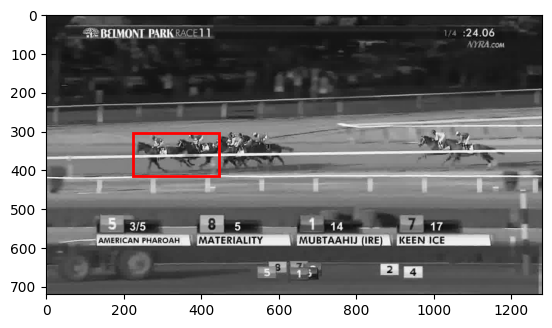

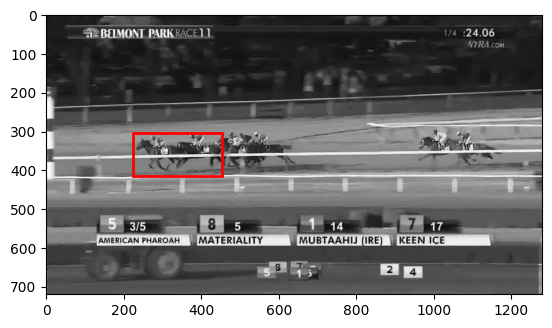

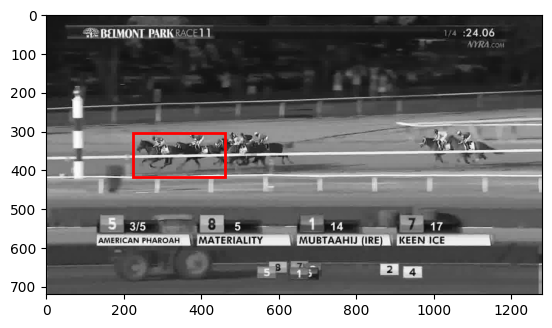

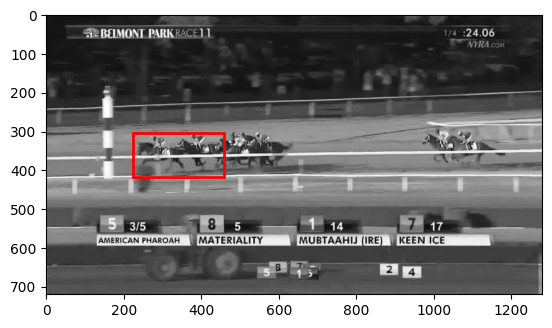

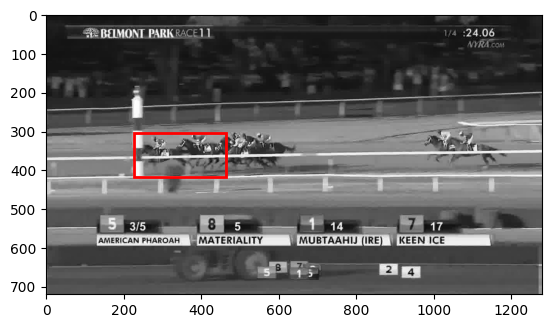

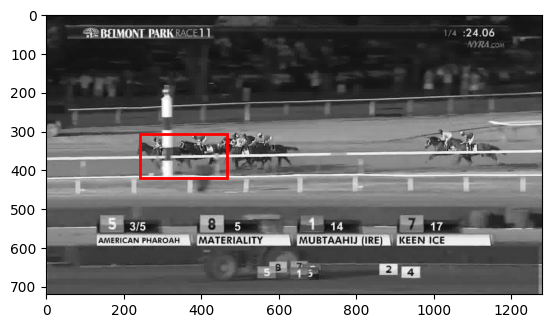

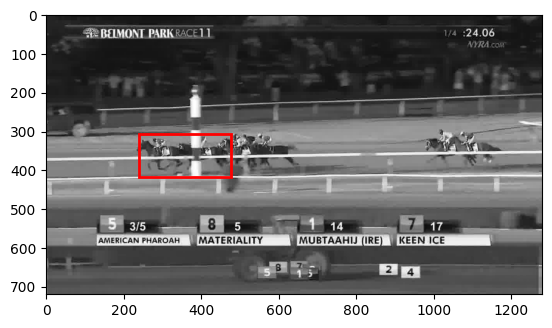

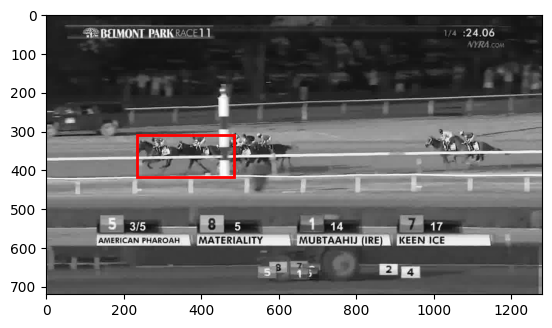

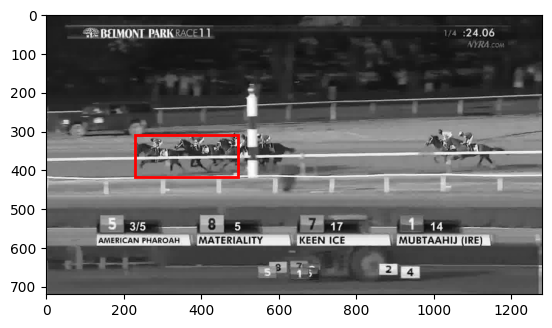

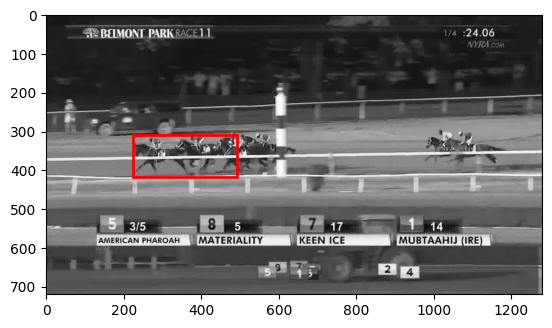

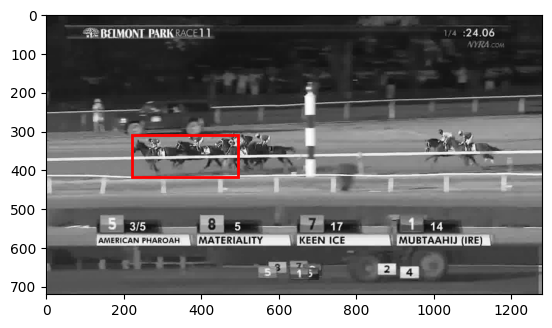

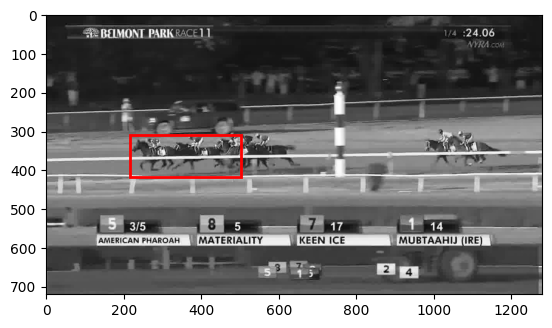

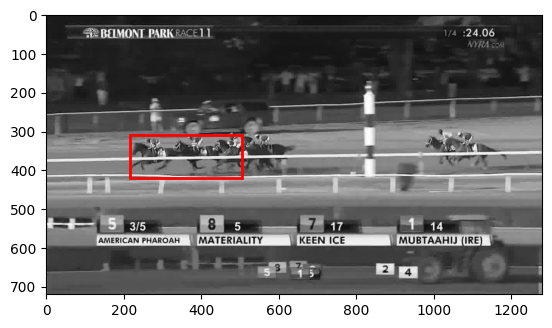

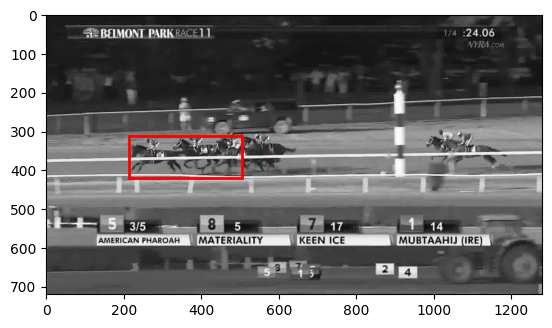

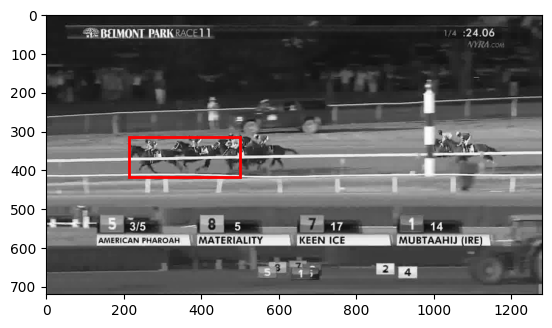

In [91]:
# Test your algorithm and visualize results!

# Load data
data_name = 'race' # could choose from (car1, car2, landing, race, ballet)
data = np.load('./data/%s.npy' % data_name)

# obtain the initial rect with format (x1, y1, x2, y2)
if data_name == 'car1':
    initial = np.array([170, 130, 290, 250])   
elif data_name == 'car2':
    initial = np.array([59, 116, 145, 151])    
elif data_name == 'landing':
    initial = np.array([440, 80, 560, 140])     
elif data_name == 'race':
    initial = np.array([170, 270, 300, 370])
elif data_name == 'ballet':
    initial = np.array([700, 210, 775, 300])     
else:
    assert False, 'the data name must be one of (car1, car2, landing, race, ballet)'

numFrames = data.shape[2]
w = initial[2] - initial[0]
h = initial[3] - initial[1]

# loop over frames
rects = []
rects.append(initial)

for i in range(numFrames-1):

    It = data[:,:,i]
    It1 = data[:,:,i+1]
    rect = rects[i]

    # run algorithm and collect rects
    M = LucasKanadeAffine(It, It1, rect)
    corners = np.array([[rect[0], rect[1], 1], 
                        [rect[2], rect[3], 1]]).transpose()
    newRect = np.matmul(M, corners).transpose().reshape((4, ))
    rects.append(newRect)

    # Visualize
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.add_patch(patches.Rectangle((rect[0], rect[1]), rect[2]-rect[0]+1, rect[3]-rect[1]+1, linewidth=2, edgecolor='red', fill=False))
    plt.imshow(It1, cmap='gray')
    plt.show()
    ax.clear()


In [ ]:
# For some transparency: we evaluate on multiple frames in a given video starting from the first frame.
# We then compare against the reference implementation and calculate the sum of all differences.
# You should not need to tune anything for the autograding. We pass in the same hyperparameters for you.
